In [2]:
import urllib, json, pandas as pd, numpy as np, sklearn.linear_model, statsmodels.api as sm, matplotlib.pyplot as plt
import urllib.request

In [3]:
start_date="2015101000"

In [4]:
end_date="2016101200"

In [5]:
window_size=7

In [6]:
topic="Cat"

In [7]:
url_template=("https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/%s/daily/%s/%s")

In [8]:
def get_time_series (topic, start, end):
    url=url_template % (topic, start, end)
    json_data=urllib.request.urlopen(url).read()
    data=json.loads(json_data)
    times=[rec['timestamp']
          for rec in data['items']]
    values=[rec['views'] for rec in data['items']]
    times_formatted=pd.Series(times).map(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:8])
    time_index=times_formatted.astype('datetime64')
    return pd.DataFrame({'views':values}, index=time_index)
    

In [9]:
get_time_series(topic, start_date, end_date)

,views
2015-10-10,8009
2015-10-11,8886
2015-10-12,9797
2015-10-13,45713
2015-10-14,10329
2015-10-15,10504
2015-10-16,9084
2015-10-17,8413
2015-10-18,9085
2015-10-19,10400


In [15]:
df=get_time_series(topic, start_date, end_date)

linear=sklearn.linear_model.LinearRegression()
linear


def line_slope(ss):
    x=np.arange(len(ss)).reshape((len(ss),1))
    linear.fit(x, ss)
    return linear.coef_

line_slope(df['views'])

array([-9.26060374])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

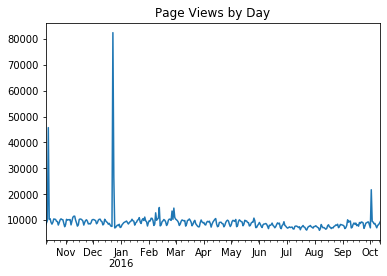

In [16]:
df['views'].plot()
plt.title("Page Views by Day")
plt.show()

In [17]:
#Remove outliers bluntly
max_views=df['views'].quantile(0.95)

In [18]:
df.views[df.views>max_views]=max_views

In [19]:
#Visualize decomposition
decomp=sm.tsa.seasonal_decompose(df['views'].values,freq=7)

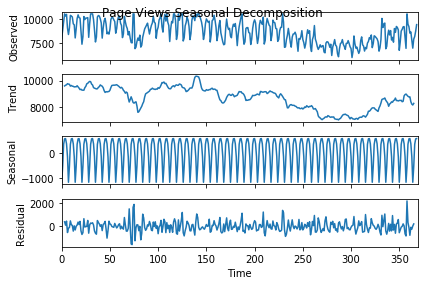

In [20]:
decomp.plot()
plt.suptitle("Page Views Seasonal Decomposition")
plt.show()

In [21]:
#For each day, add features from previous week
df['mean_lweek']=pd.Series(df['views']).rolling(window_size).mean() 

In [22]:
df['max_lweek']=pd.Series(df['views']).rolling(window_size).max() 

In [23]:
df['min_lweek']=pd.Series(df['views']).rolling(window_size).min() 

In [24]:
df['slope']=pd.Series(df['views']).rolling(window_size).apply(line_slope)

/Users/tatsianasokalava/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


In [25]:
df['total_vweek']=pd.Series.rolling(df['views'], window_size).sum()

In [26]:
df['day_of_week']=df.index.astype(int)%7

In [27]:
day_of_week_cols=pd.get_dummies(df['day_of_week'])

In [28]:
df=pd.concat([df,day_of_week_cols], axis=1)

In [29]:
df

,views,mean_lweek,max_lweek,min_lweek,slope,total_vweek,day_of_week,0,1,2,3,4,5,6
2015-10-10,8009.0,NaN,NaN,NaN,NaN,NaN,2,0,0,1,0,0,0,0
2015-10-11,8886.0,NaN,NaN,NaN,NaN,NaN,3,0,0,0,1,0,0,0
2015-10-12,9797.0,NaN,NaN,NaN,NaN,NaN,4,0,0,0,0,1,0,0
2015-10-13,10552.2,NaN,NaN,NaN,NaN,NaN,5,0,0,0,0,0,1,0
2015-10-14,10329.0,NaN,NaN,NaN,NaN,NaN,6,0,0,0,0,0,0,1
2015-10-15,10504.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0
2015-10-16,9084.0,9594.457143,10552.2,8009.0,249.750000,67161.2,1,0,1,0,0,0,0,0
2015-10-17,8413.0,9652.171429,10552.2,8413.0,-103.328571,67565.2,2,0,0,1,0,0,0,0
2015-10-18,9085.0,9680.600000,10552.2,8413.0,-273.550000,67764.2,3,0,0,0,1,0,0,0
2015-10-19,10400.0,9766.742857,10552.2,8413.0,-179.842857,68367.2,4,0,0,0,0,1,0,0


In [32]:
#Make target variable that we want to predict(views next week):
#Must pad with NaNs so dates will line up
df['total_views_next_week']=list(df['total_vweek'][window_size:])+[np.nan for _ in range(window_size)]


In [34]:
indep_var=['mean_lweek', 'max_lweek', 'min_lweek', 'slope']

In [35]:
dep_var='total_views_next_week'

In [71]:
n_records=int(df.dropna().shape[0]/2)
n_records

178

In [72]:
test_data=df.dropna()[:n_records]
test_data

,views,mean_lweek,max_lweek,min_lweek,slope,total_vweek,day_of_week,0,1,2,3,4,5,6,total_views_next_week
2015-10-16,9084.0,9594.457143,10552.2,8009.0,249.750000,67161.2,1,0,1,0,0,0,0,0,67397.0
2015-10-17,8413.0,9652.171429,10552.2,8413.0,-103.328571,67565.2,2,0,0,1,0,0,0,0,67040.0
2015-10-18,9085.0,9680.600000,10552.2,8413.0,-273.550000,67764.2,3,0,0,0,1,0,0,0,66952.0
2015-10-19,10400.0,9766.742857,10552.2,8413.0,-179.842857,68367.2,4,0,0,0,0,1,0,0,66620.0
2015-10-20,10327.0,9734.571429,10504.0,8413.0,-7.607143,68142.0,5,0,0,0,0,0,1,0,66746.0
2015-10-21,10236.0,9721.285714,10504.0,8413.0,131.035714,68049.0,6,0,0,0,0,0,0,1,66672.0
2015-10-22,9522.0,9581.000000,10400.0,8413.0,221.500000,67067.0,0,1,0,0,0,0,0,0,67266.0
2015-10-23,9414.0,9628.142857,10400.0,8413.0,132.607143,67397.0,1,0,1,0,0,0,0,0,66655.0
2015-10-24,8056.0,9577.142857,10400.0,8056.0,-209.428571,67040.0,2,0,0,1,0,0,0,0,66003.0
2015-10-25,8997.0,9564.571429,10400.0,8056.0,-341.892857,66952.0,3,0,0,0,1,0,0,0,65192.0


In [73]:
train_data=df.dropna()[n_records:]

In [76]:
linear.fit(train_data[indep_var], train_data[dep_var])
test_preds_array=linear.predict(test_data[indep_var])
test_preds=pd.Series(test_preds_array, index=test_data.index)
print("Corr on test data:", test_data[dep_var].corr(test_preds))

Corr on test data: 0.5292073142310807
